In [1]:
import collections
import fasttext
import gzip
import json
import math
import nltk
import pickle
import scipy.sparse
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zstandard as zstd

from collections import Counter
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from scipy.sparse import dok_matrix

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/olam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class Zreader:

    def __init__(self, file, chunk_size=16384):
        '''Init method'''
        self.fh = open(file,'rb')
        self.chunk_size = chunk_size
        self.dctx = zstd.ZstdDecompressor()
        self.reader = self.dctx.stream_reader(self.fh)
        self.buffer = ''


    def readlines(self):
        '''Generator method that creates an iterator for each line of JSON'''
        while True:
            chunk = self.reader.read(self.chunk_size).decode(errors="ignore")
            if not chunk:
                break
            lines = (self.buffer + chunk).split("\n")

            for line in lines[:-1]:
                yield line

            self.buffer = lines[-1]


## Get list of channels in ```channelcrawler.csv```

In [50]:
df_channelcrawler = pd.read_csv('/dlabdata1/youtube_large/channelcrawler.csv')

In [51]:
df_channelcrawler.head()

,category,join_date,link,name,subscribers,videos
0,Film and Animation,2017-05-21,http://www.youtube.com/channel/UCBJuEqXfXTdcPS...,MagnusNation,65100,28
1,Entertainment,2011-12-13,http://www.youtube.com/channel/UCkNW9Q1VR_aeZ6...,Mago Dario Animazion...,60200,48
2,Music,2013-09-13,http://www.youtube.com/channel/UC1xcnrpcF59FWW...,Mägo de Oz - Topic,40200,395
3,Music,2008-03-17,http://www.youtube.com/channel/UCXhkGgooXHDNwg...,Mago Merlino,14800,838
4,Entertainment,2014-10-19,http://www.youtube.com/channel/UCvZGsuvKlYOGiZ...,MAGO TOMÁS,26200,31


In [52]:
df_channelcrawler.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164648 entries, 0 to 164647
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   category     164462 non-null  object
 1   join_date    164647 non-null  object
 2   link         164648 non-null  object
 3   name         164633 non-null  object
 4   subscribers  164648 non-null  int64 
 5   videos       164648 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 7.5+ MB


In [53]:
df_channelcrawler['channel_id'] = df_channelcrawler['link'].apply(lambda x: x.replace('http://www.youtube.com/channel/', ''))

In [54]:
df_channelcrawler.head()

,category,join_date,link,name,subscribers,videos,channel_id
0,Film and Animation,2017-05-21,http://www.youtube.com/channel/UCBJuEqXfXTdcPS...,MagnusNation,65100,28,UCBJuEqXfXTdcPSbGO9qqn1g
1,Entertainment,2011-12-13,http://www.youtube.com/channel/UCkNW9Q1VR_aeZ6...,Mago Dario Animazion...,60200,48,UCkNW9Q1VR_aeZ6uht83jJVQ
2,Music,2013-09-13,http://www.youtube.com/channel/UC1xcnrpcF59FWW...,Mägo de Oz - Topic,40200,395,UC1xcnrpcF59FWWELtZvJTdg
3,Music,2008-03-17,http://www.youtube.com/channel/UCXhkGgooXHDNwg...,Mago Merlino,14800,838,UCXhkGgooXHDNwgJXmoTSN7g
4,Entertainment,2014-10-19,http://www.youtube.com/channel/UCvZGsuvKlYOGiZ...,MAGO TOMÁS,26200,31,UCvZGsuvKlYOGiZTsxwJNS5Q


In [57]:
df_channelcrawler.shape

(164648, 7)

In [62]:
df_channelcrawler_100000sub = df_channelcrawler[df_channelcrawler['subscribers'] >= 100000]

In [9]:
#store in a set since it will be faster to check if a channel is in channelcrawler
set_channelcrawler = set(df_channelcrawler['channel_id'])

In [63]:
set_channelcrawler_100000sub = set(df_channelcrawler_100000sub['channel_id'])

## Remove non-english channels

Here, I use langdetect

Fishing for characters from different alphabets may let us with french-spanish-etc channels -> discuss with Manoel

In [10]:
from langdetect import detect
from langdetect import detect_langs

from collections import Counter

In [11]:
list_en_videos = []

In [12]:
reader = Zreader("/dlabdata1/youtube_large/yt_metadata_all.jsonl.zst", chunk_size=2**28)

In [13]:
def detect_language(text):
    '''Method that detect the language of the argument using langdetect'''
    
    # Create list to store the language detections
    detections = []
    
    for i in range(5):
        detections.append(detect(text))
        
    # Create the counter to get the most detected language
    c = Counter(detections)
    language_detected, _ = c.most_common()[0]
    
    print(detections)
    return language_detected

In [14]:
text = "Bonjour, je m'appelle Olivier et j'ai twenty ans"

In [15]:
detect_language(text)

['nl', 'fr', 'fr', 'fr', 'fr']


'fr'

## To ignore - Testing

In [ ]:
idx = 0
for line in reader.readlines():
    idx += 1
    
    if idx % 250 == 0:
        break
        
    # line is a str dict, res is the dict corresponding to the str dict
    res = json.loads(line)
    
    title = res['title']
    description = res['description']
    
    if detect(title) == 'en' and res['channel_id'] in set_channelcrawler:
        list_en_videos.append(res)
    
    try: 
        if description != '':
            best_lang1 = str(detect_langs(description)[0])
            best_lang2 = str(detect_langs(description)[0])
            best_lang3 = str(detect_langs(description)[0])
            print('Detect language from description: ' + detect(description))
            print('Probability1 of languages from description: ' + best_lang1)
            print('Probability2 of languages from description: ' + best_lang2)
            print('Probability3 of languages from description: ' + best_lang3)
            #print('')
            
            language, prob = best_lang1.split(':')[0], float(best_lang1.split(':')[1])
            
            if prob < 0.8:
                print('Top1 lang detect from description with prob: ' + language + ' ' + str(prob))
                print('Title of the video : ' + title)
                print('Channel of the video : ' + res['channel_id'])
                print('')
        elif title != '':
            try:
                print('Detect language from title: ' + detect(title))
                print('Probability of languages from title: ' + str(detect_langs(title)))
                print('')
            except:
                print('Language not known for the video')
                
    except:
        try:
            if title != '':
                print('Detect language from title: ' + detect(title))
                print('Probability of languages from title: ' + str(detect_langs(title)))
                print('')
        except:
            print('Language not known for the video')
    
        
    

In [17]:
list_en_videos[0]

{'categories': 'Howto & Style',
 'channel_id': 'UCzzzZ3-icktxbC3j7hkWqRw',
 'crawl_date': '2019-11-08 05:24:10.745916',
 'description': 'Benvenuto to Ciao Citalia, the blog from the leading Italian holiday specialist. Make Ciao Citalia your go-to for destination guides, food and wine features, recipes, and inspiration for things to see and do on your next holiday to Italy. You’ll also find first-hand accounts from our team on their travels through Italy, from a Tuscan honeymoon to a trip on the famous Venice Simplon-Orient-Express.\n\nTake a look now at https://ciao.citalia.com/',
 'dislike_count': 2,
 'display_id': 'FV_kEBb1XqU',
 'duration': 63,
 'like_count': 17,
 'tags': 'Citalia,blog,italy,vog,videos,video,italian,food,wine,rome,venice,florence,milan,amalfi,coast,beach,holiday,travel,tips',
 'title': 'Ciao Citalia | The blog from the Italian holiday specialists',
 'upload_date': '2017-06-02 00:00:00',
 'view_count': 1334}

In [18]:
len(list_en_videos)

165

## Check rankings.jsonl

In [19]:
rankings = []

In [20]:
with open('/dlabdata1/youtube_large/rankings.jsonl', 'r') as json_file:
    json_list = list(json_file)

In [21]:
for json_str in json_list:
    res = json.loads(json_str)
    rankings.append(res)

In [22]:
len(rankings)

164677

In [23]:
rankings[0]

{'success': True,
 'data': {'social blade rank': 389823,
  'subscriber rank': 231223,
  'video views rank': 192084,
  'country rank': 3,
  'film rank': 11654,
  'country': 'Anguilla'},
 'crawl_time': '2020-02-17 16:40:48.336406',
 'channel': 'UCBJuEqXfXTdcPSbGO9qqn1g'}

## Title, Tag and (Description) pre-processing per video

In [24]:
video_test = list_en_videos[0]

In [25]:
video_test['title']

'Ciao Citalia | The blog from the Italian holiday specialists'

In [26]:
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/olam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Step 1 : lowercase, remove stop words and tokenize

In [27]:
stop_words = set(stopwords.words('english'))

In [28]:
tokenizer = RegexpTokenizer(r'\w+')

In [29]:
tokens_per_video = []

In [30]:
title_tokens = [w for w in tokenizer.tokenize(video_test['title'].lower()) if not w in stop_words]

In [31]:
tag_tokens = [w for w in tokenizer.tokenize(video_test['tags'].lower()) if not w in stop_words]

In [32]:
print(title_tokens)

['ciao', 'citalia', 'blog', 'italian', 'holiday', 'specialists']


In [33]:
print(tag_tokens)

['citalia', 'blog', 'italy', 'vog', 'videos', 'video', 'italian', 'food', 'wine', 'rome', 'venice', 'florence', 'milan', 'amalfi', 'coast', 'beach', 'holiday', 'travel', 'tips']


In [34]:
# We want to keep duplicates !!
tokens_per_video = title_tokens + tag_tokens

In [35]:
print(tokens_per_video)

['ciao', 'citalia', 'blog', 'italian', 'holiday', 'specialists', 'citalia', 'blog', 'italy', 'vog', 'videos', 'video', 'italian', 'food', 'wine', 'rome', 'venice', 'florence', 'milan', 'amalfi', 'coast', 'beach', 'holiday', 'travel', 'tips']


#### Step 2 : Stemming

Ask Manoel : Stemming vs Lemmatization for the task ? We have a huge dataset so we shouldn't juste lemmatization since it would take too much time right ? For tags, lemmatization make no sense since we do not have any sentences

In [36]:
from nltk.stem.snowball import SnowballStemmer

In [37]:
s_stemmer = SnowballStemmer(language='english')

In [38]:
tokens_per_video_stemmed = [s_stemmer.stem(w) for w in tokens_per_video]

In [39]:
print(tokens_per_video_stemmed)

['ciao', 'citalia', 'blog', 'italian', 'holiday', 'specialist', 'citalia', 'blog', 'itali', 'vog', 'video', 'video', 'italian', 'food', 'wine', 'rome', 'venic', 'florenc', 'milan', 'amalfi', 'coast', 'beach', 'holiday', 'travel', 'tip']


#### Step 3 : Putting it together

In [40]:
import nltk
import collections

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/olam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
s_stemmer = SnowballStemmer(language='english')

In [42]:
def get_freq_tokens_per_video(video):
    title_tokens = [w for w in tokenizer.tokenize(video['title'].lower()) if not w in stop_words]
    tag_tokens = [w for w in tokenizer.tokenize(video['tags'].lower()) if not w in stop_words]
    
    # We want to keep duplicates !!
    tokens_per_video = title_tokens + tag_tokens

    # Stemming
    stemmed_tokens_per_video = ([s_stemmer.stem(w) for w in tokens_per_video])
    
    # Return a Counter object of the tokens
    return collections.Counter(stemmed_tokens_per_video)

In [44]:
print(get_freq_tokens_per_video(list_en_videos[0]))

Counter({'citalia': 2, 'blog': 2, 'italian': 2, 'holiday': 2, 'video': 2, 'ciao': 1, 'specialist': 1, 'itali': 1, 'vog': 1, 'food': 1, 'wine': 1, 'rome': 1, 'venic': 1, 'florenc': 1, 'milan': 1, 'amalfi': 1, 'coast': 1, 'beach': 1, 'travel': 1, 'tip': 1})


## Create Sparse Matrix 

In [45]:
from scipy.sparse import dok_matrix
from sys import getsizeof

In [46]:
list_stemmed_tokens = set()

In [47]:
for video in list_en_videos:
    tokens_per_video = get_freq_tokens_per_video(video).keys()
    list_stemmed_tokens.update(tokens_per_video)

In [48]:
list_stemmed_tokens = list(list_stemmed_tokens)

In [49]:
len(list_stemmed_tokens)

891

In [50]:
size_of_tokens_dict = len(list_stemmed_tokens)

In [51]:
number_videos = len(list_en_videos)

In [52]:
S = dok_matrix((number_videos, size_of_tokens_dict))

In [53]:
def fill_underlying_dict(freq_tokens_per_video, list_stemmed_tokens, dict_freq_tokens_for_sparse_matrix, idx_video):
    '''Method to fill the underlying dictionnary in order to 
    update the sparse matrix incrementally by videos'''
    
    for key in freq_tokens_per_video.keys():
        
        # Column index in the sparse matrix (one column for each token)
        idy_token = list_stemmed_tokens.index(key)
    
        # Filling the underlying dict
        dict_freq_tokens_for_sparse_matrix[(idx_video, idy_token)] = freq_tokens_per_video[key]
    

In [54]:
# Row index in the sparse matrix (one row for each video)
idx_video = 0

for video in list_en_videos:
    # For each video, create a underlying dictionnary for filling the sparse matrix efficiently
    dict_freq_tokens_for_sparse_matrix = {}
    
    # Get the tokens for each video and theirs number of occurences
    freq_tokens_per_video = get_freq_tokens_per_video(video)
    
    # Fill the underlying dict
    fill_underlying_dict(freq_tokens_per_video, list_stemmed_tokens, dict_freq_tokens_for_sparse_matrix, idx_video)
        
    # Update the Sparse Matrix
    dict.update(S, dict_freq_tokens_for_sparse_matrix)
    
    # Increment Row index for next video
    idx_video += 1

In [55]:
S

<165x891 sparse matrix of type '<class 'numpy.float64'>'
	with 2772 stored elements in Dictionary Of Keys format>

In [56]:
len(list_en_videos)

165

In [ ]:
S.items()

## Group freq_tokens_per_videos by channel

In [58]:
tokens_per_channel = {}
channels_in_dict = set()

In [59]:
for vid in list_en_videos:
    if vid['channel_id'] in channels_in_dict:
        tokens_per_channel[vid['channel_id']] = tokens_per_channel[vid['channel_id']] + get_freq_tokens_per_video(vid)
    else:
        tokens_per_channel[vid['channel_id']] = get_freq_tokens_per_video(vid)
        channels_in_dict.add(vid['channel_id'])

## Analysis of the data : check noisyness of videos and channels

In [3]:
n_vid_per_1000_view = {}
n_views_list = set()

In [4]:
n_vid_per_channel = {}
channels = set()

In [5]:
def update_vid_views(n_vid_per_1000_view, n_views_list, video):
    
    try:
        n_view = math.ceil(video['view_count'] / 1000)
    except KeyError:
        n_view = None
        
    if n_view in n_views_list:
        n_vid_per_1000_view[n_view] += 1
    else:
        n_vid_per_1000_view[n_view] = 1
        n_views_list.add(n_view)

In [6]:
def update_vid_per_channel(n_vid_per_channel, channels, video):
    
    channel = video['channel_id']
    
    if channel in channels:
        n_vid_per_channel[channel] += 1
    else:
        n_vid_per_channel[channel] = 1
        channels.add(channel)

In [15]:
reader = Zreader("/dlabdata1/youtube_large/yt_metadata_all.jsonl.zst", chunk_size=2**28)

In [8]:
view_counts = []
dates = []

In [9]:
idx = 0
for line in reader.readlines():
    #start_iter = time.time()
    idx += 1
    
    if idx % 10000000 == 0:
        print('Processed ' + str(idx) + ' videos.')
        
    video = json.loads(line)
    try:
        view_counts.append(video['view_count'])
    except KeyError:
        None
    try:
        dates.append(video['upload_date'])
    except KeyError:
        None

Processed 10000000 videos.
Processed 20000000 videos.
Processed 30000000 videos.
Processed 40000000 videos.
Processed 50000000 videos.
Processed 60000000 videos.
Processed 70000000 videos.
Processed 80000000 videos.


In [10]:
min(dates)

'2005-05-24 00:00:00'

In [11]:
max(dates)

'2019-11-20 00:00:00'

In [16]:
idx = 0

# Variable that contains the idx of every non english vid and that
# belongs to a channel in channelcrawler.csv TO BE USED IN SECOND ITER
idx_vid_to_consider = set()

# Variable first instanciated as set to check existing tokens efficiently, 
# which will be a list in order to get the index for each tokens
list_stemmed_tokens = set()

for line in reader.readlines():
    #start_iter = time.time()
    idx += 1
    
    if idx % 1000000 == 0:
        print('Processed ' + str(idx) + ' videos.')
        
        
    # line is a str dict, video is the dict corresponding to the str dict
    video = json.loads(line)
    
    update_vid_views(n_vid_per_1000_view, n_views_list, video)
    update_vid_per_channel(n_vid_per_channel, channels, video)

Processed 1000000 videos.
Processed 2000000 videos.
Processed 3000000 videos.
Processed 4000000 videos.
Processed 5000000 videos.
Processed 6000000 videos.
Processed 7000000 videos.
Processed 8000000 videos.
Processed 9000000 videos.
Processed 10000000 videos.
Processed 11000000 videos.
Processed 12000000 videos.
Processed 13000000 videos.
Processed 14000000 videos.
Processed 15000000 videos.
Processed 16000000 videos.
Processed 17000000 videos.
Processed 18000000 videos.
Processed 19000000 videos.
Processed 20000000 videos.
Processed 21000000 videos.
Processed 22000000 videos.
Processed 23000000 videos.
Processed 24000000 videos.
Processed 25000000 videos.
Processed 26000000 videos.
Processed 27000000 videos.
Processed 28000000 videos.
Processed 29000000 videos.
Processed 30000000 videos.
Processed 31000000 videos.
Processed 32000000 videos.
Processed 33000000 videos.
Processed 34000000 videos.
Processed 35000000 videos.
Processed 36000000 videos.
Processed 37000000 videos.
Processed 

In [17]:
n_vid_per_1000_view.pop(None)

674

In [18]:
number_total_vid = idx
print('Total number of videos : ' + str(number_total_vid))

Total number of videos : 85421645


In [19]:
len(n_vid_per_1000_view)

52730

In [20]:
n_vid_per_1000_view[1] / number_total_vid * 100

33.96078593429101

In [21]:
n_vid_per_1000_view[1]

29009862

In [22]:
list(n_vid_per_1000_view.keys())[52729]

41652

In [23]:
len(n_vid_per_1000_view) / 30

1757.6666666666667

In [24]:
n_vid_per_1000_view = dict(sorted(n_vid_per_1000_view.items()))

In [29]:
sorted_view_counts = sorted(view_counts)

In [30]:
len(sorted_view_counts)

85420971

In [31]:
sorted_view_counts[-1]

6509934494

(array([76718., 31595., 17411., 10740.,  7198.,  4986.,  3875.,  2817.,
         2297.,  1849.,  1532.,  1211.,  1046.,   897.,   734.,   671.,
          563.,   516.,   422.,   419.,   387.,   357.,   304.,   278.,
          248.,   217.,   193.,   187.,   176.,   156.]),
 array([1.00000000e+00, 1.15433333e+02, 2.29866667e+02, 3.44300000e+02,
        4.58733333e+02, 5.73166667e+02, 6.87600000e+02, 8.02033333e+02,
        9.16466667e+02, 1.03090000e+03, 1.14533333e+03, 1.25976667e+03,
        1.37420000e+03, 1.48863333e+03, 1.60306667e+03, 1.71750000e+03,
        1.83193333e+03, 1.94636667e+03, 2.06080000e+03, 2.17523333e+03,
        2.28966667e+03, 2.40410000e+03, 2.51853333e+03, 2.63296667e+03,
        2.74740000e+03, 2.86183333e+03, 2.97626667e+03, 3.09070000e+03,
        3.20513333e+03, 3.31956667e+03, 3.43400000e+03]),
 <a list of 30 Patch objects>)

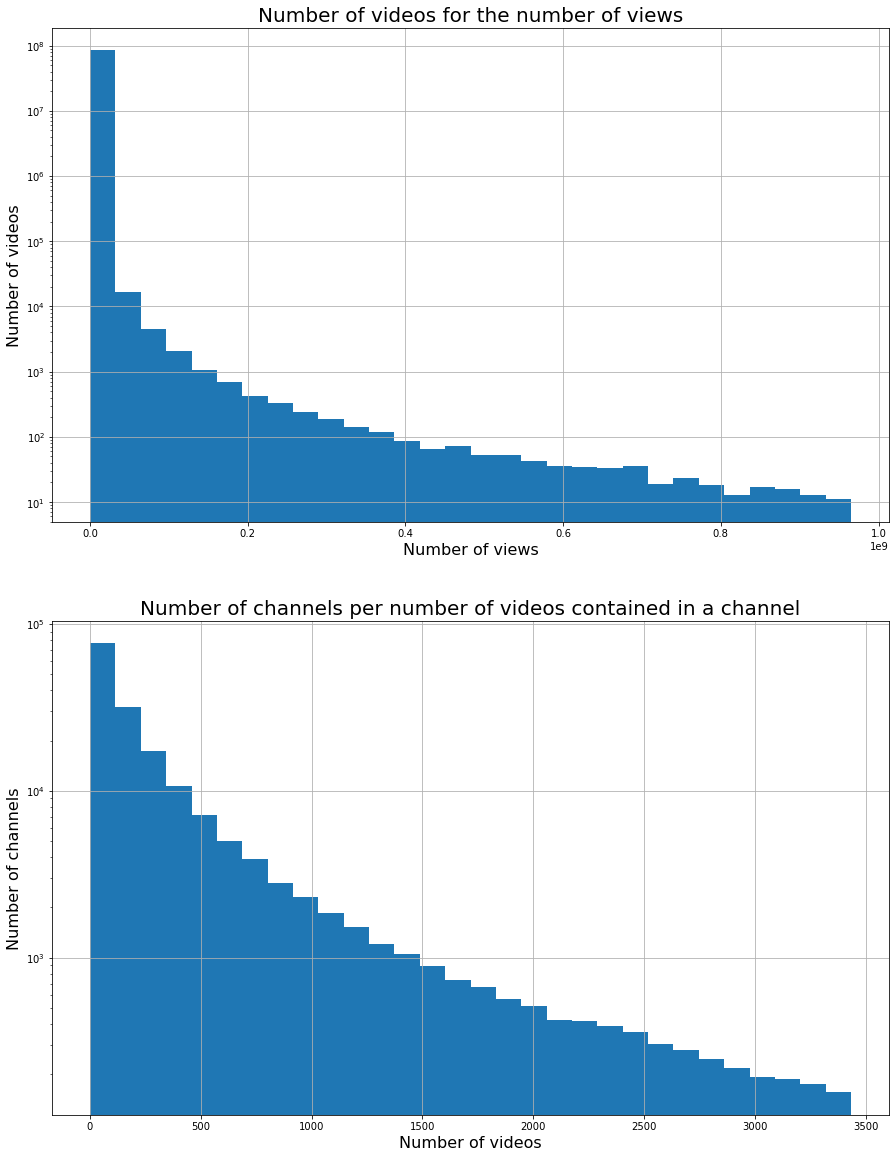

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))

ax1.set_title('Number of videos for the number of views', fontsize=20)
ax1.set_xlabel('Number of views', fontsize=16)
ax1.set_ylabel('Number of videos', fontsize=16)

ax1.set_yscale('log')
ax1.grid('on')

ax1.hist(sorted(view_counts)[:85420800], bins=30)

ax2.set_title('Number of channels per number of videos contained in a channel', fontsize=20)
ax2.set_xlabel('Number of videos', fontsize=16)
ax2.set_ylabel('Number of channels', fontsize=16)

ax2.set_yscale('log')
ax2.grid('on')

ax2.hist(sorted(list(n_vid_per_channel.values()))[:170000], bins=30)



In [33]:
fig.savefig('/home/olam/test_plot')

In [38]:
n_vid_per_channel_sorted = sorted(list(n_vid_per_channel.values()))

In [39]:
n_vid_per_channel_sorted_sub = n_vid_per_channel_sorted[:150000]

In [40]:
len(channels)

173574

In [41]:
n_channels_with_1_vid = 0
for i, n in enumerate(n_vid_per_channel_sorted):
    if n ==21:
        n_channels_with_1_vid = i
        break
        
print('Number of channels with only 1 uploaded videos : ' + str(n_channels_with_1_vid))

Number of channels with only 1 uploaded videos : 22877


In [23]:
8543 / len(channels) * 100 # with 1 vid

4.921820088262066

In [24]:
14102 / len(channels) * 100 # less or eq than 10 vid

8.124488690702524

In [42]:
22877 / len(channels) * 100 # less or eq than 20 vid

13.179969350248308

In [25]:
channels_with_1_vid = []
for channel_id, n_vid in n_vid_per_channel.items():
    if n_vid == 1:
        channels_with_1_vid.append(channel_id)

In [27]:
len(channels_with_1_vid)

8543

In [28]:
with open('/dlabdata1/youtube_large/olam/channels_with_1_vid.pickle', 'wb') as f:
    pickle.dump(channels_with_1_vid, f)
f.close()

In [45]:
68/85

0.8

In [34]:
len(sorted_view_counts)

85420971

In [35]:
video_sub10kviews = []

for elem in sorted_view_counts:
    video_sub10kviews.append(elem)
    if elem >= 10000:
        break

In [48]:
sorted_view_counts[85420813]

1003276408

In [49]:
85420971 - 85420813

158

In [59]:
n_vid_10000view = []
for nview in sorted_view_counts:
    if nview < 10000:
        n_vid_10000view.append(nview)
    else:
        break

In [60]:
len(n_vid_10000view)

58477100

In [65]:
reader = Zreader("/dlabdata1/youtube_large/yt_metadata_all.jsonl.zst", chunk_size=2**28)

In [ ]:
idx = 0

idx_to_considered_chan100000_vid10000 = []

for line in reader.readlines():
    idx += 1
    
    if idx % 1000000 == 0:
        print('Processed ' + str(idx) + ' videos.')
        
        
    # line is a str dict, video is the dict corresponding to the str dict
    video = json.loads(line)
    
    try:
        view_counts = video['view_count']
    except KeyError:
        view_counts = 0
    
    if view_counts >= 10000 and video['channel_id'] in set_channelcrawler_100000sub:
        idx_to_considered_chan100000_vid10000.append(idx)

In [68]:
len(idx_to_considered_chan100000_vid10000)

18964188

#### Updated with the new dataset

In [34]:
from datetime import datetime

In [37]:
# List that contains the number of views for all videos
n_views = []

# First video from dataset
first_video_date = datetime.today()

# Last video from dataset
last_video_date = datetime(2000, 1, 1)

In [38]:
with gzip.open('/dlabdata1/youtube_large/yt_metadata_en.jsonl.gz', 'rb') as f:
    
    for i, line in enumerate(f):
        
        if i >= 1:
            break
        
        video = json.loads(line)
        print(video)

{'categories': 'Film & Animation', 'channel_id': 'UCzWrhkg9eK5I8Bm3HfV-unA', 'crawl_date': '2019-10-31 20:19:26.270363', 'description': 'Lego City Police Lego Firetruck Cartoons about Lego City Movie for kids with a nice long video to keep the kids entertained while learning and having fun with the Lego City characters from Lego City undercover. Thanks for watching!', 'dislike_count': 1.0, 'display_id': 'SBqSc91Hn9g', 'duration': 1159, 'like_count': 8.0, 'tags': 'lego city,lego police,lego city police,lego city episodes,videos de lego city,lego policia,lego bomberos,lego fire truck,lego firetruck,lego police chase,lego robbers,lego cartoons,lego movies,lego videos for kids', 'title': 'Lego City Police Lego Firetruck Cartoons about Lego City Movie for kids Episodes', 'upload_date': '2016-09-28 00:00:00', 'view_count': 1057.0}


In [46]:
with gzip.open('/dlabdata1/youtube_large/yt_metadata_en.jsonl.gz', 'rb') as f:
    
    for i, line in enumerate(f):
        
        if i%2000000 == 0:
            print('Checked ' + str(i) + ' videos...')
        
        video = json.loads(line)
        
        try:
            n_views.append(int(video['view_count']))
        except:
            None
        
        try:
            uploaded_date = datetime.strptime(video['upload_date'][:10], '%Y-%m-%d')

            if uploaded_date >= last_video_date:
                last_video_date = uploaded_date

            if uploaded_date <= first_video_date:
                first_video_date = uploaded_date
        except:
            None


Checked 0 videos...
Checked 2000000 videos...
Checked 4000000 videos...
Checked 6000000 videos...
Checked 8000000 videos...
Checked 10000000 videos...
Checked 12000000 videos...
Checked 14000000 videos...
Checked 16000000 videos...
Checked 18000000 videos...
Checked 20000000 videos...
Checked 22000000 videos...
Checked 24000000 videos...
Checked 26000000 videos...
Checked 28000000 videos...
Checked 30000000 videos...
Checked 32000000 videos...
Checked 34000000 videos...
Checked 36000000 videos...
Checked 38000000 videos...
Checked 40000000 videos...
Checked 42000000 videos...
Checked 44000000 videos...
Checked 46000000 videos...
Checked 48000000 videos...
Checked 50000000 videos...
Checked 52000000 videos...
Checked 54000000 videos...
Checked 56000000 videos...
Checked 58000000 videos...
Checked 60000000 videos...
Checked 62000000 videos...
Checked 64000000 videos...
Checked 66000000 videos...
Checked 68000000 videos...
Checked 70000000 videos...
Checked 72000000 videos...


In [47]:
first_video_date

datetime.datetime(2005, 5, 24, 0, 0)

In [48]:
last_video_date

datetime.datetime(2019, 11, 20, 0, 0)

In [51]:
len(n_views)

73301516

In [52]:
n_views = sorted(n_views)

In [65]:
n_views[-136]

1003276408

In [62]:
n_views_sub_billion = n_views[:-136]

In [66]:
len(n_views_sub_billion)

73301380

In [63]:
n_views_sub_billion[-1]

999383011

In [119]:
n_views_sub_thousand = 0
for elem in n_views:
    if elem <= 1000:
        n_views_sub_thousand += 1
    else:
        break

In [120]:
n_views_sub_thousand

24559810

(array([7.3278859e+07, 1.3948000e+04, 3.6770000e+03, 1.6990000e+03,
        9.0700000e+02, 5.4800000e+02, 3.7200000e+02, 2.7200000e+02,
        1.9900000e+02, 1.5000000e+02, 1.2000000e+02, 8.6000000e+01,
        7.4000000e+01, 6.3000000e+01, 5.2000000e+01, 5.2000000e+01,
        4.3000000e+01, 3.3000000e+01, 3.7000000e+01, 2.6000000e+01,
        3.1000000e+01, 2.6000000e+01, 1.8000000e+01, 1.9000000e+01,
        8.0000000e+00, 1.9000000e+01, 1.3000000e+01, 1.1000000e+01,
        8.0000000e+00, 1.0000000e+01]),
 array([0.00000000e+00, 3.33127670e+07, 6.66255341e+07, 9.99383011e+07,
        1.33251068e+08, 1.66563835e+08, 1.99876602e+08, 2.33189369e+08,
        2.66502136e+08, 2.99814903e+08, 3.33127670e+08, 3.66440437e+08,
        3.99753204e+08, 4.33065971e+08, 4.66378738e+08, 4.99691506e+08,
        5.33004273e+08, 5.66317040e+08, 5.99629807e+08, 6.32942574e+08,
        6.66255341e+08, 6.99568108e+08, 7.32880875e+08, 7.66193642e+08,
        7.99506409e+08, 8.32819176e+08, 8.66131943e+

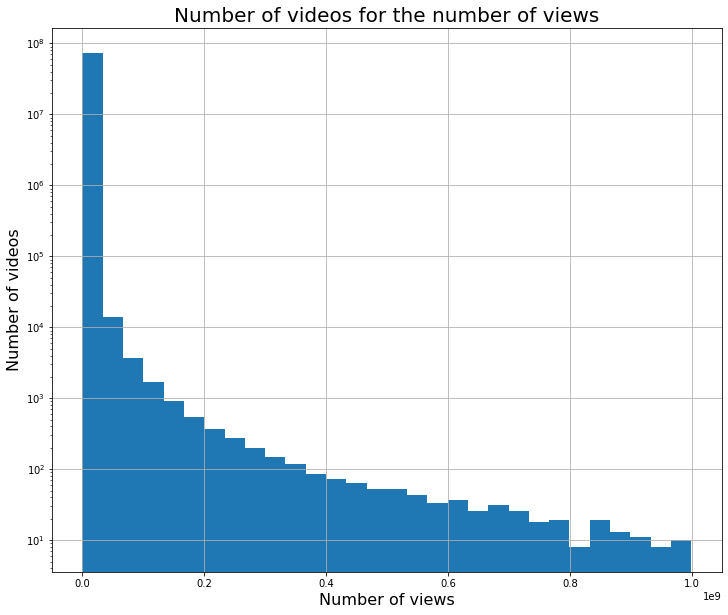

In [68]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_title('Number of videos for the number of views', fontsize=20)
ax.set_xlabel('Number of views', fontsize=16)
ax.set_ylabel('Number of videos', fontsize=16)

ax.set_yscale('log')
ax.grid('on')

ax.hist(n_views_sub_billion, bins=30)

In [69]:
fig.savefig('n_vid_per_view')

In [5]:
df_channelcrawler = pd.read_csv(
        '/dlabdata1/youtube_large/df_channels_en.tsv.gz', sep='\t')
df_channelcrawler.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [12]:
df_channelcrawler.describe()

,subscribers_cc,videos_cc,subscriber_rank_sb,weights
count,1.364700e+05,136470.000000,1.364700e+05,136470.000000
mean,2.466022e+05,699.784231,3.570087e+05,7.349363
std,1.150096e+06,4524.980928,2.711139e+05,5.277328
min,1.000000e+04,10.000000,3.000000e+00,2.086500
25%,1.888575e+04,70.000000,1.161305e+05,4.231500
50%,4.240000e+04,175.000000,3.015670e+05,6.444000
75%,1.370000e+05,443.000000,5.704942e+05,9.243500
max,1.121395e+08,461923.000000,1.030844e+06,53.150500


In [8]:
# List that contains the number of subscribers for all channels
n_sub = list(df_channelcrawler['subscribers_cc'])

# List that contains the number of videos per channels
n_vid_per_channel = list(df_channelcrawler['videos_cc'])

In [9]:
len(n_sub)

136470

In [10]:
len(n_vid_per_channel)

136470

In [11]:
df_channelcrawler.shape

(136470, 8)

In [72]:
n_sub = sorted(n_sub)
n_vid_per_channel = sorted(n_vid_per_channel)

In [79]:
n_vid_per_channel[-50]

106505

In [77]:
n_sub[-50]

23400000

(array([1.33217e+05, 1.79100e+03, 5.13000e+02, 2.51000e+02, 1.22000e+02,
        8.20000e+01, 7.70000e+01, 4.40000e+01, 3.40000e+01, 2.60000e+01,
        3.80000e+01, 3.00000e+01, 2.30000e+01, 3.30000e+01, 2.10000e+01,
        1.60000e+01, 7.00000e+00, 5.00000e+00, 5.00000e+00, 5.00000e+00,
        1.20000e+01, 9.00000e+00, 7.00000e+00, 5.00000e+00, 4.00000e+00,
        3.00000e+00, 3.00000e+00, 2.00000e+00, 6.00000e+00, 2.90000e+01]),
 array([1.00000000e+01, 3.55373333e+03, 7.09746667e+03, 1.06412000e+04,
        1.41849333e+04, 1.77286667e+04, 2.12724000e+04, 2.48161333e+04,
        2.83598667e+04, 3.19036000e+04, 3.54473333e+04, 3.89910667e+04,
        4.25348000e+04, 4.60785333e+04, 4.96222667e+04, 5.31660000e+04,
        5.67097333e+04, 6.02534667e+04, 6.37972000e+04, 6.73409333e+04,
        7.08846667e+04, 7.44284000e+04, 7.79721333e+04, 8.15158667e+04,
        8.50596000e+04, 8.86033333e+04, 9.21470667e+04, 9.56908000e+04,
        9.92345333e+04, 1.02778267e+05, 1.06322000e+05])

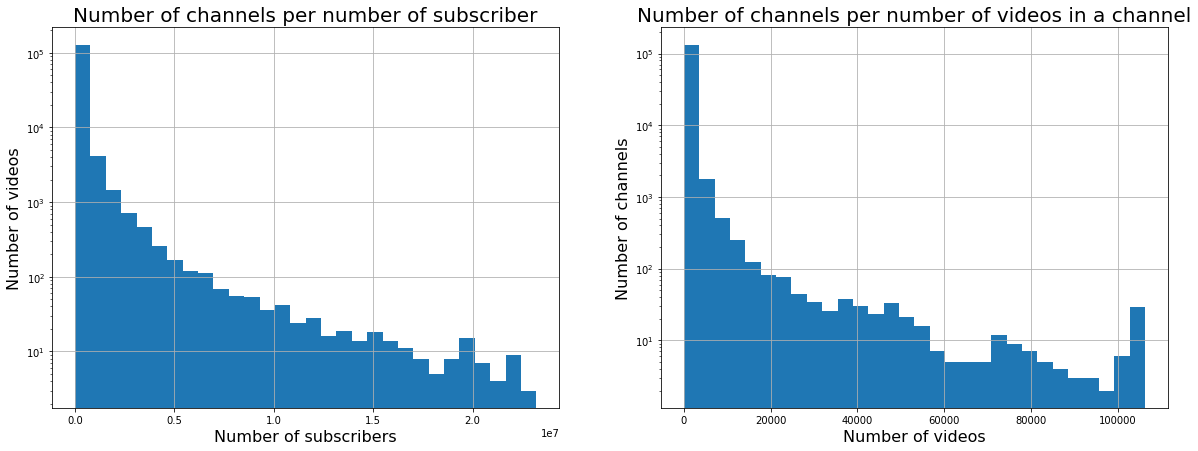

In [124]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

ax1.set_title('Number of channels per number of subscriber', fontsize=20)
ax1.set_xlabel('Number of subscribers', fontsize=16)
ax1.set_ylabel('Number of videos', fontsize=16)

ax1.set_yscale('log')
ax1.grid('on')

ax1.hist(n_sub[:-50], bins=30)

ax2.set_title('Number of channels per number of videos in a channel', fontsize=20)
ax2.set_xlabel('Number of videos', fontsize=16)
ax2.set_ylabel('Number of channels', fontsize=16)

ax2.set_yscale('log')
ax2.grid('on')

ax2.hist(n_vid_per_channel[:-50], bins=30)




In [125]:
fig.savefig('channels_informations')

In [84]:
S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/S_full.npz')

In [87]:
S

<17000000x2320172 sparse matrix of type '<class 'numpy.uint8'>'
	with 434000892 stored elements in Compressed Sparse Row format>

In [88]:
def remove_zero_rows(M):
    '''Function that removes all rows from sparse matrix M that contains only zero.

    Parameter
    ----------
    M : sparse matrix

    Returns
    ----------
    The same sparse matrix as in parameter without the zero rows
    '''
    num_nonzeros = np.diff(M.indptr)
    return M[num_nonzeros != 0]

In [89]:
S = remove_zero_rows(S)

In [90]:
S

<16412321x2320172 sparse matrix of type '<class 'numpy.uint8'>'
	with 434000892 stored elements in Compressed Sparse Row format>

In [91]:
sum_rows = S.sum(axis=1)

In [95]:
sum_rows = np.squeeze(np.asarray(sum_rows))

In [98]:
np.average(sum_rows)

47.84212720431193

In [103]:
category_count = {}

In [104]:
with gzip.open('/dlabdata1/youtube_large/yt_metadata_en.jsonl.gz', 'rb') as f:
    
    for i, line in enumerate(f):
        
        if i%5000000 == 0:
            print('Checked ' + str(i) + ' videos...')
        
        video = json.loads(line)
        

        try:
            category = video['categories']

            if category not in category_count.keys():
                category_count[category] = 1
            else:
                category_count[category] += 1
        except:
            None



Checked 0 videos...
Checked 5000000 videos...
Checked 15000000 videos...
Checked 20000000 videos...
Checked 25000000 videos...
Checked 30000000 videos...
Checked 35000000 videos...
Checked 40000000 videos...
Checked 45000000 videos...
Checked 50000000 videos...
Checked 55000000 videos...
Checked 60000000 videos...
Checked 65000000 videos...
Checked 70000000 videos...


In [105]:
category_count

{'Film & Animation': 2359736,
 'Gaming': 13720303,
 'Education': 3795564,
 'People & Blogs': 6910666,
 'Entertainment': 12276397,
 'Autos & Vehicles': 2256967,
 'Comedy': 1172503,
 'Sports': 4354412,
 'News & Politics': 8881022,
 'Music': 8305003,
 'Howto & Style': 3968127,
 'Science & Technology': 2403004,
 'Travel & Events': 1096565,
 'Pets & Animals': 645508,
 'Nonprofits & Activism': 777449,
 '': 1522,
 'Shows': 41,
 'Movies': 5}

In [106]:
video_counts = category_count.values()
categories = category_count.keys()

In [107]:
categories

dict_keys(['Film & Animation', 'Gaming', 'Education', 'People & Blogs', 'Entertainment', 'Autos & Vehicles', 'Comedy', 'Sports', 'News & Politics', 'Music', 'Howto & Style', 'Science & Technology', 'Travel & Events', 'Pets & Animals', 'Nonprofits & Activism', '', 'Shows', 'Movies'])

In [108]:
video_counts

dict_values([2359736, 13720303, 3795564, 6910666, 12276397, 2256967, 1172503, 4354412, 8881022, 8305003, 3968127, 2403004, 1096565, 645508, 777449, 1522, 41, 5])

<ipython-input-129-26469cdf3bd0>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, Rotation=60)
<ipython-input-129-26469cdf3bd0>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels(categories, Rotation=60)


<BarContainer object of 18 artists>

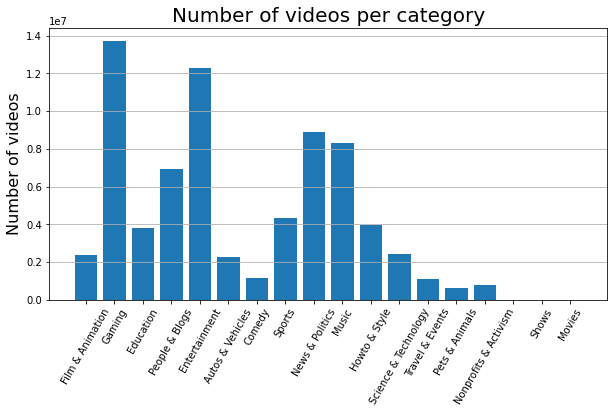

In [129]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_title('Number of videos per category', fontsize=20)
ax.set_ylabel('Number of videos', fontsize=16)

ax.set_xticklabels(categories, Rotation=60) 
ax.yaxis.grid()

ax.bar(categories, video_counts)

In [118]:
fig.savefig('n_vid_per_cat')